#setup:
- connect to google drive in this step

In [ ]:
import pandas as pd
import math
import numpy as np
import os
import glob
import sklearn
import pickle
import glob
import scipy.io
import cv2
from google.colab.patches import cv2_imshow
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_path = '/content/drive/MyDrive/demo-me-2021-07-14'
output_dir = os.path.join(project_path, "behaviors/")
classifiers_dir = os.path.join(project_path, "classifiers/")
if not os.path.exists(output_dir):
  os.mkdir(output_dir)

In [ ]:
def get_data(individual, bodypart, h5_file):
  mouse_data = h5_file.xs(individual,level='individuals',axis=1)
  out_data = mouse_data.xs(bodypart,level='bodyparts',axis=1)
  out_data.columns = out_data.columns.droplevel("scorer")
  output = out_data.copy()
  return output

In [ ]:
def within_area(area_vector, input_coor):
  area_startx = area_vector[0]
  area_starty = area_vector[1]
  area_distx = area_vector[2]
  area_disty = area_vector[3]
  x = input_coor["x"].iloc[0]
  y = input_coor["y"].iloc[0]
  if (area_startx <= x <= (area_startx+area_distx)) and (area_starty <= y <= (area_starty+area_disty)):
    result = 1
  else:
    result = 0
  return result

In [ ]:
def euclid_dist(point1_coor, point2_coor):
  point1 = np.array((point1_coor["x"].iloc[0], point1_coor["y"].iloc[0]))
  point2 = np.array((point2_coor["x"].iloc[0], point2_coor["y"].iloc[0]))
  output_dist = np.linalg.norm(point1 - point2)
  return output_dist

In [ ]:
def euclid_angle(pointa_coor, pointb_coor, pointc_coor):
  #angle_{pointa, pointb, pointc}
  a = np.array((pointa_coor["x"].iloc[0], pointa_coor["y"].iloc[0]))
  b = np.array((pointb_coor["x"].iloc[0], pointb_coor["y"].iloc[0]))
  c = np.array((pointc_coor["x"].iloc[0], pointc_coor["y"].iloc[0]))

  ba = a - b
  bc = c - b

  cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
  angle = np.arccos(cosine_angle)

  result = np.degrees(angle)
  return result

#Open some corrected_behavior data data:

In [ ]:
video_name = 'training'

corrected_behavior_file = open(project_path + "/classifiers/" + video_name + '_corrected_behavior.pickle', 'rb')
corrected_behavior = pickle.load(corrected_behavior_file)
corrected_behavior_file.close()

# area_vec = [area_startx, area_starty, area_distx, area_disty]
female_side_mat = scipy.io.loadmat(project_path + "/classifiers/" + video_name + "_female_side.mat")
female_side_vec = female_side_mat['croprect'][0]
male_side_mat = scipy.io.loadmat(project_path + "/classifiers/" + video_name + "_male_side.mat")
male_side_vec = male_side_mat['croprect'][0]

h5_file = pd.read_hdf(project_path +'/classifiers/'+ video_name + 'DLC_dlcrnetms5_demoJul14shuffle0_20000_el_filtered.h5')
[nframes, ncols] = h5_file.shape

#features
- whether both tailbases exist (boolean)
- if exist, the euclid distance between them, if not exist, -1
- for i=30:i+30

### total: 122 features

### _Note_: Euclidean distance doesn't care about which mouse is which, the distance/difference will still be the same

#analysis setup

In [ ]:
# get all data ready for accessing as needed later on
mouse1_feature_points = {}
mouse1_feature_points['snout'] = get_data('mus1', 'snout', h5_file)
mouse1_feature_points['shoulder'] = get_data('mus1', 'shoulder', h5_file)
mouse1_feature_points['spine1'] = get_data('mus1', 'spine1', h5_file)
mouse1_feature_points['spine2'] = get_data('mus1', 'spine2', h5_file)
mouse1_feature_points['spine3'] = get_data('mus1', 'spine3', h5_file)
mouse1_feature_points['spine4'] = get_data('mus1', 'spine4', h5_file)
mouse1_feature_points['tailbase'] = get_data('mus1', 'tailbase', h5_file)

mouse2_feature_points = {}
mouse2_feature_points['snout'] = get_data('mus2', 'snout', h5_file)
mouse2_feature_points['shoulder'] = get_data('mus2', 'shoulder', h5_file)
mouse2_feature_points['spine1'] = get_data('mus2', 'spine1', h5_file)
mouse2_feature_points['spine2'] = get_data('mus2', 'spine2', h5_file)
mouse2_feature_points['spine3'] = get_data('mus2', 'spine3', h5_file)
mouse2_feature_points['spine4'] = get_data('mus2', 'spine4', h5_file)
mouse2_feature_points['tailbase'] = get_data('mus2', 'tailbase', h5_file)

mouse3_feature_points = {}
mouse3_feature_points['snout'] = get_data('mus3', 'snout', h5_file)
mouse3_feature_points['shoulder'] = get_data('mus3', 'shoulder', h5_file)
mouse3_feature_points['spine1'] = get_data('mus3', 'spine1', h5_file)
mouse3_feature_points['spine2'] = get_data('mus3', 'spine2', h5_file)
mouse3_feature_points['spine3'] = get_data('mus3', 'spine3', h5_file)
mouse3_feature_points['spine4'] = get_data('mus3', 'spine4', h5_file)
mouse3_feature_points['tailbase'] = get_data('mus3', 'tailbase', h5_file)


In [ ]:
# male_side_vec = [x, y, width, height]; female_side_vec = [x, y, width, height]
relevant_area = female_side_vec.copy()
# relevant area is female_side_vec + male_side_vec size exactly right next to each other with 50 buffer
relevant_area[2] = female_side_vec[2] + male_side_vec[2] + 50

In [ ]:
def torso_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['snout'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['shoulder'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine1'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine2'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine3'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['spine4'].loc[[i]]):
    return 1
  elif within_area(area_vector, feature_points['tailbase'].loc[[i]]):
    return 1
  else:
    return 0

In [ ]:
def snout_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['snout'].loc[[i]]):
    result = 1
  else:
    result = 0
  return result

In [ ]:
def shoulder_in_area(area_vector, mouse_num, i):
  # finds if any part of torso at all is in area
  if mouse_num == 1:
    feature_points = mouse1_feature_points
  elif mouse_num == 2:
    feature_points = mouse2_feature_points
  elif mouse_num == 3:
    feature_points = mouse3_feature_points

  if within_area(area_vector, feature_points['shoulder'].loc[[i]]):
    result = 1
  else:
    result = 0
  return result

# get features code:

In [ ]:
def get_i_features(i, first_mouse_feature_points, second_mouse_feature_points):
  if second_mouse_feature_points == 0:
    return np.array([0, -1])
  elif within_area(relevant_area, first_mouse_feature_points['tailbase'].loc[[i]]) and within_area(relevant_area, second_mouse_feature_points['tailbase'].loc[[i]]):
    dist = euclid_dist(first_mouse_feature_points['tailbase'].loc[[i]], second_mouse_feature_points['tailbase'].loc[[i]])
    return np.array([1, dist])
  else:
    return np.array([0, -1])

In [ ]:
def calculate_i_features(total_frames):
  i_features = np.empty([total_frames, 2])
  
  for i in range(0, total_frames):
    
    # 2 mice detected
    if torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 2, i):
      first_mouse_feature_points = mouse1_feature_points
      second_mouse_feature_points = mouse2_feature_points

    elif torso_in_area(relevant_area, 1, i) and torso_in_area(relevant_area, 3, i):
      first_mouse_feature_points = mouse1_feature_points
      second_mouse_feature_points = mouse3_feature_points

    elif torso_in_area(relevant_area, 2, i) and torso_in_area(relevant_area, 3, i):
      first_mouse_feature_points = mouse2_feature_points
      second_mouse_feature_points = mouse3_feature_points


    # 1 mouse detected
    elif torso_in_area(relevant_area, 1, i):
      first_mouse_feature_points = mouse1_feature_points
      second_mouse_feature_points = 0
      
    elif torso_in_area(relevant_area, 2, i):
      first_mouse_feature_points = mouse2_feature_points
      second_mouse_feature_points = 0
      
    elif torso_in_area(relevant_area, 3, i):
      first_mouse_feature_points = mouse3_feature_points
      second_mouse_feature_points = 0

    # no mouse detected
    else:
      first_mouse_feature_points = 0
      second_mouse_feature_points = 0

    i_features[i, 0:2] = get_i_features(i, first_mouse_feature_points, second_mouse_feature_points)
  
  return i_features

In [ ]:
def get_input_features(frame_examples, i_features):
  input_features = np.array([i_features[i[0]-29:i[0]+31, :].flatten() for i in frame_examples])

  return np.nan_to_num(input_features, nan=-1)

# calculate i_features

In [ ]:
# 3 min
i_features = calculate_i_features(36000)

In [ ]:
with open(project_path + "/classifiers/" +video_name+ '_i_features.pickle', 'wb') as f:
    pickle.dump(i_features, f)

#mount example features

In [ ]:
forest_example_behavior = corrected_behavior.copy()

In [ ]:
# find all frames with at least 1 individual
# takes a little bit but not too long (e.g. 54s)
training_mount_examples = [None] * 36000
n_examples = 0
for i in range(30, 35970):
  if forest_example_behavior["behavior"][i] == 'mount':
    training_mount_examples[n_examples] = [i]
    n_examples = n_examples + 1
training_mount_examples[n_examples:] = []

num_mount_examples = len(training_mount_examples)
print(num_mount_examples)

5744


In [ ]:
training_mount_features = get_input_features(training_mount_examples, i_features)

#nonmount example features
- requires previous section (mount example features) to have already run

In [ ]:
forest_example_behavior = corrected_behavior.copy()
for i in range(0, 36001):
  beh = corrected_behavior["behavior"][i]
  if beh == 'mount':
    # this is probably redundant but oh well it takes 3s
    # 30 frames = 1 second surround
    forest_example_behavior["behavior"][i-30:i] = 'ignore'
    forest_example_behavior["behavior"][i:i+30] = 'ignore'

In [ ]:
# find all frames with at least 1 individual
training_nonmount_examples = [None] * 36000
n_examples = 0
for i in range(30, 35970):
  if forest_example_behavior["behavior"][i] != 'ignore':
    training_nonmount_examples[n_examples] = [i]
    n_examples = n_examples + 1
training_nonmount_examples[n_examples:] = []

num_nonmount_examples = len(training_nonmount_examples)
print(num_nonmount_examples)

28186


In [ ]:
training_nonmount_features = get_input_features(training_nonmount_examples, i_features)

#all features together

In [ ]:
random_indices = np.random.choice(training_nonmount_features.shape[0], num_nonmount_examples, replace=False)
final_training_nonmount_features = training_nonmount_features[random_indices]

random_indices = np.random.choice(training_nonmount_features.shape[0], num_nonmount_examples, replace=False)
final_testing_nonmount_features = training_nonmount_features[random_indices]

In [ ]:
print(num_mount_examples)
print(num_nonmount_examples)

5744
28186


In [ ]:
print(training_mount_features.mean(axis=0)[0:122])
print(training_nonmount_features.mean(axis=0)[0:122])

[ 0.71117688 79.08071957  0.71117688 79.01975305  0.71100279 78.9626596
  0.71082869 78.90613007  0.71082869 78.87223775  0.7104805  78.81638609
  0.7104805  78.79363244  0.71030641 78.74809507  0.71030641 78.72227336
  0.71030641 78.70072044  0.70995822 78.62792018  0.70995822 78.601315
  0.70978412 78.54699551  0.70995822 78.51006248  0.71030641 78.48548045
  0.71013231 78.41535307  0.71013231 78.38803001  0.71030641 78.34400499
  0.71030641 78.31412981  0.7104805  78.28675574  0.7106546  78.25197918
  0.7104805  78.19411208  0.71013231 78.10715563  0.71030641 78.06942961
  0.7104805  78.06247308  0.71117688 78.08643716  0.71169916 78.09619269
  0.71169916 78.06156273  0.71204735 78.05113393  0.71204735 78.01810687
  0.71204735 77.98720513  0.71239554 77.99952488  0.71256964 77.99220571
  0.71309192 78.02631413  0.71326602 78.02016219  0.71309192 77.9838898
  0.71291783 77.97711079  0.71291783 77.98442517  0.71274373 77.97045471
  0.71256964 77.93308376  0.71222145 77.89788739  0.712

In [ ]:
training_features = np.vstack((training_mount_features, final_training_nonmount_features))
testing_features = np.vstack((training_mount_features, final_testing_nonmount_features))

In [ ]:
training_labels = np.zeros(training_features.shape[0], dtype=int)
training_labels[0:num_mount_examples] = 1

testing_labels = np.zeros(testing_features.shape[0], dtype=int)
testing_labels[0:num_mount_examples] = 1

In [ ]:
print(num_mount_examples)
print(num_nonmount_examples)

5744
28186


In [ ]:
# save features and labels
with open(output_dir + video_name + '_training_features.pickle', 'wb') as f:
    pickle.dump(training_features, f)
with open(output_dir + video_name + '_training_labels.pickle', 'wb') as f:
    pickle.dump(training_labels, f)

#features from multiple videos

In [ ]:
training_features = np.array([])
training_labels = np.array([])

In [ ]:
video_name = 'PZ71_1'
video_training_features_file = open(output_dir + video_name + '_training_features.pickle', 'rb')
video_training_features = pickle.load(video_training_features_file)
video_training_features_file.close()

video_training_labels_file = open(output_dir + video_name + '_training_labels.pickle', 'rb')
video_training_labels = pickle.load(video_training_labels_file)
video_training_labels_file.close()

In [ ]:
training_features = np.vstack([training_features, video_training_features]) if training_features.size else video_training_features
training_labels = np.vstack([training_labels, video_training_labels]) if training_labels.size else video_training_labels

#smote

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


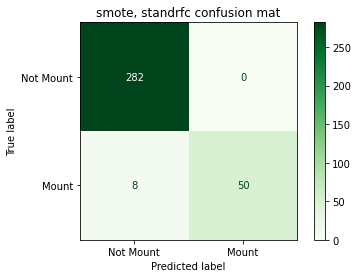

In [ ]:
#Importing essential libraries
import matplotlib.pyplot as plt
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(training_features, training_labels)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.01, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SMOTE SRF model
#scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
#print('Mean f1: %.3f' % mean(scores['test_f1']))
#print('Mean recall: %.3f' % mean(scores['test_recall']))
#print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels, test_size=0.01, stratify=training_labels)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=['Not Mount', 'Mount'], cmap='Greens')
plt.title('smote, standrfc confusion mat')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(testing_features, training_labels, test_size=0.95, stratify=training_labels)
y_pred = SMOTE_SRF.predict(testing_features)
# Making the Confusion Matrix
print(pd.crosstab(testing_labels, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted      0     1
Actual                
0          28184     2
1            763  4981


# save classifer

In [ ]:
# save the model
with open(classifiers_dir + 'classifer_1203v2.pickle', 'wb') as f:
  pickle.dump(SMOTE_SRF, f)

#pickle to csv

In [ ]:
# load a pickle
video_name ='PZ70_1'
pickle_file = open(output_dir + video_name +'_intro_events.pickle', 'rb')
pickle_data = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
import csv

with open(output_dir + video_name +'_intro_events.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(pickle_data.columns)
    for i in range(0, pickle_data.shape[0]):
      # write the data
      writer.writerow(pickle_data.values[i,:])